##**Using AlexNET for REAL/FAKE Image Classification**


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Reshape, Concatenate, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras import layers
import kagglehub
from tensorflow.keras.losses import BinaryCrossentropy

path = kagglehub.dataset_download("birdy654/cifake-real-and-ai-generated-synthetic-images")

print("Path to dataset files:", path)

image_dim = {'height':32, 'width':32, 'channels':3}
batch_size = 1000


Path to dataset files: C:\Users\yagiz\.cache\kagglehub\datasets\birdy654\cifake-real-and-ai-generated-synthetic-images\versions\3


# **1-)Download the Dataset**

Found 100000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.
Training Classes:
['FAKE', 'REAL']


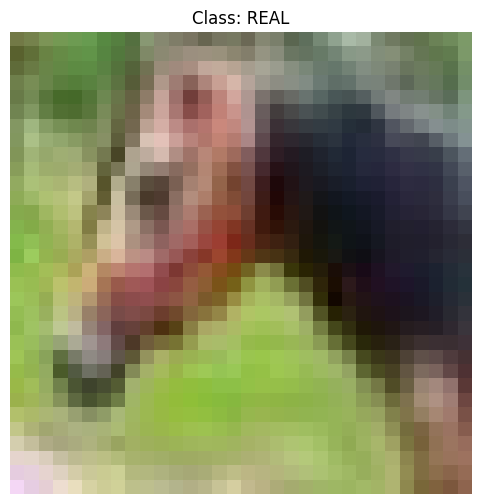

Image shape: (32, 32, 3)
Label: 1 (REAL)


In [ ]:
#Load the training data
train_data = tf.keras.preprocessing.image_dataset_from_directory(path + "/train" , seed= 123, image_size=(image_dim['height'],image_dim['width']),batch_size=batch_size )
val_data = tf.keras.preprocessing.image_dataset_from_directory(path + "/test" , seed= 123, image_size=(image_dim['height'],image_dim['width']),batch_size=batch_size  )

print("Training Classes:")
class_names = train_data.class_names
print(class_names)

for images, labels in train_data.take(1):
    first_image = images[2].numpy()
    first_label = labels[2].numpy()

    # Display the image
    plt.figure(figsize=(6, 6))
    plt.imshow(first_image.astype("uint8"))
    plt.title(f"Class: {class_names[first_label]}")
    plt.axis("off")
    plt.show()

    print(f"Image shape: {first_image.shape}")
    print(f"Label: {first_label} ({class_names[first_label]})")


# **2-) Normalize the data**

In [ ]:
def normalize(image,label):
    return (tf.cast(image, tf.float32) / 255.0, label)

In [ ]:

train_data = train_data.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)

train_data = train_data.prefetch(tf.data.AUTOTUNE)

In [ ]:
val_data = val_data.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)

val_data = val_data.prefetch(tf.data.AUTOTUNE)


In [ ]:
for images, labels in train_data.take(1):
    print(f"Normalized batch shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")
    break

Normalized batch shape: (1000, 32, 32, 3)
Labels shape: (1000,)


# **3-) Create the AlexNet Model For 32*32 images**

In [ ]:
def alexnet(input_shape=(32, 32, 3), num_classes=2):
    inputs = Input(shape=input_shape)

    x = Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu')(inputs)
    x = MaxPooling2D(pool_size=2)(x)


    x = Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)


    x = Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)


    x = Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)


    x = Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)


    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    return Model(inputs=inputs, outputs=outputs)
model = alexnet()
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 8, 8, 128)      │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,436,609 (9.29 MB)

 Trainable params: 2,436,609 (9.29 MB)

 Non-trainable params: 0 (0.00 B)

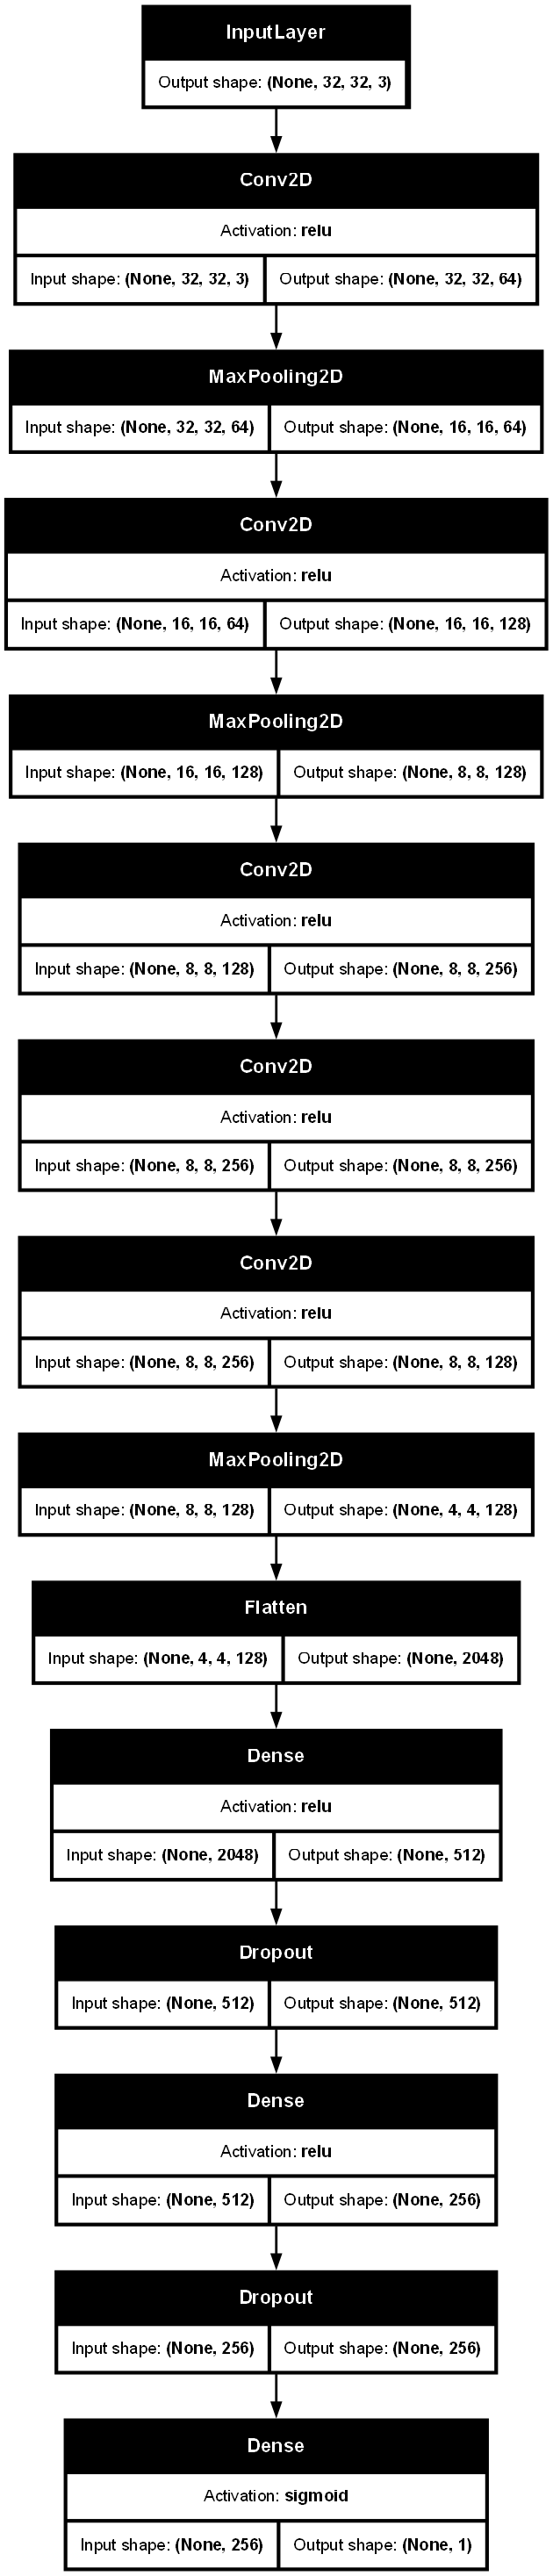

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=False,
    show_layer_activations=True,
    dpi=100
)

Check for debugging

In [ ]:
print("Debugging dataset shapes:")
for x_batch, y_batch in train_data.take(1):
    print(f"X shape: {x_batch.shape}")
    print(f"Y shape: {y_batch.shape}")
    print(f"Model expects input shape: {model.input_shape}")
    print(f"Model expects output shape: {model.output_shape}")

    # Check for NaN values
    print(f"X contains NaN: {np.isnan(x_batch.numpy()).any()}")
    print(f"Y contains NaN: {np.isnan(y_batch.numpy()).any()}")

    # Check value ranges
    print(f"X min: {np.min(x_batch.numpy())}, X max: {np.max(x_batch.numpy())}")

Debugging dataset shapes:
X shape: (1000, 32, 32, 3)
Y shape: (1000,)
Model expects input shape: (None, 32, 32, 3)
Model expects output shape: (None, 1)
X contains NaN: False
Y contains NaN: False
X min: 0.0, X max: 1.0


# **5-)Start the training**

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='BinaryCrossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.AUC()
    ]
)

In [ ]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    verbose=1
)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 719s 7s/step - accuracy: 0.6756 - auc_2: 0.7474 - loss: 0.5668 - precision_2: 0.6826 - recall_2: 0.6302 - val_accuracy: 0.8812 - val_auc_2: 0.9510 - val_loss: 0.2862 - val_precision_2: 0.8705 - val_recall_2: 0.8957
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 621s 6s/step - accuracy: 0.8950 - auc_2: 0.9592 - loss: 0.2580 - precision_2: 0.8909 - recall_2: 0.8988 - val_accuracy: 0.9230 - val_auc_2: 0.9791 - val_loss: 0.1923 - val_precision_2: 0.9055 - val_recall_2: 0.9445
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 618s 6s/step - accuracy: 0.9271 - auc_2: 0.9796 - loss: 0.1822 - precision_2: 0.9277 - recall_2: 0.9254 - val_accuracy: 0.9345 - val_auc_2: 0.9831 - val_loss: 0.1684 - val_precision_2: 0.9297 - val_recall_2: 0.9401
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 576s 6s/step - accuracy: 0.9392 - auc_2: 0.9847 - loss: 0.1567 - precision_2: 0.9376 - recall_2: 0.9402 - val_accuracy: 0.9301 - val_auc_2: 0.9870 - val_loss: 0.1840 - val_precision_2: 0.8912 - v

# **6-) Get the results of the model and test in on validation data**

In [ ]:
# Evaluate the model on validation data
evaluation = model.evaluate(val_data, verbose=1)
print(f"Validation Loss: {evaluation[0]:.4f}")
print(f"Validation Accuracy: {evaluation[1]:.4f}")
print(f"Validation Precision: {evaluation[2]:.4f}")
print(f"Validation Recall: {evaluation[3]:.4f}")
print(f"Validation AUC: {evaluation[4]:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.9529 - auc_2: 0.9889 - loss: 0.1391 - precision_2: 0.9495 - recall_2: 0.9574
Validation Loss: 0.1366
Validation Accuracy: 0.9541
Validation Precision: 0.9514
Validation Recall: 0.9571
Validation AUC: 0.9892


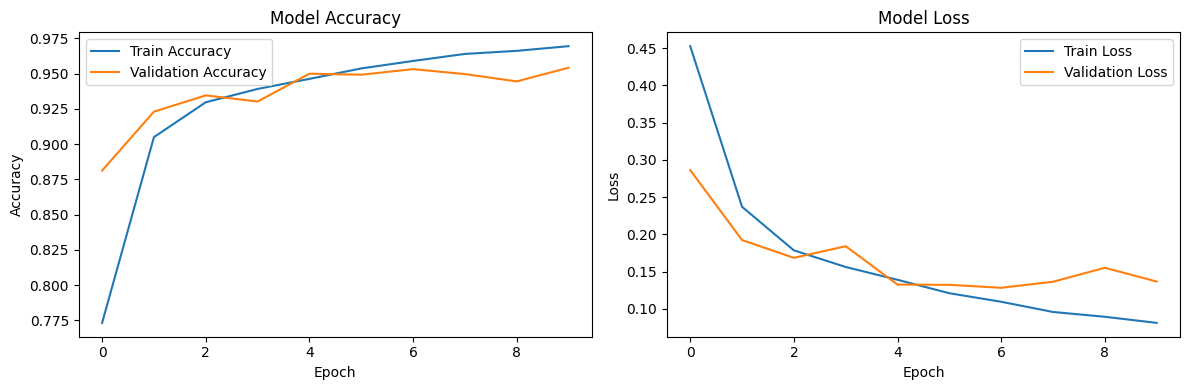

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()